In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import csv
import fasttext

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AoIP/train.csv').drop(['id','keyword', 'location' ], axis = 1)
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AoIP/test.csv').drop(['id','keyword', 'location' ], axis = 1)
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Предобработка данных

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from functools import lru_cache

class Text_preproc():
    def __init__(self, language):
        if language == 'english':
            self.bad_reg = re.compile('[^a-z\s\d #]')
            self.stopwords = set(stopwords.words('english'))
            eng_lemmatizer = WordNetLemmatizer()
            @lru_cache(maxsize=10 ** 6)
            def lru_eng_lemmatizer(word):
                return eng_lemmatizer.lemmatize(word)
            self.lemmatizer = lru_eng_lemmatizer
        else:
             raise NotImplementedError('Not supported language')


    def remove_URL(self, text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)


    def remove_html(self, text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)


    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

            
    def __call__(self, text):
        text = self.remove_URL(text)
        text = self.remove_html(text)
        text = self.remove_emoji(text)
        text = text.lower()
        text = re.sub(self.bad_reg, ' ', text)
        text = re.sub('\n|\t', ' ', text)
        text = re.sub(' +', ' ', text)
        lemmas = [self.lemmatizer(word) for word in text.split()]
        lemmas = [word for word in lemmas if word not in self.stopwords]
        
        return ' '.join(lemmas) 

In [5]:
preprocessor = Text_preproc('english')

df_train['clear_text'] = df_train['text'].apply(preprocessor)
df_test['clear_text'] = df_test['text'].apply(preprocessor)

df_train.head()

,text,target,clear_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason #earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive #wildfires evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


In [6]:
df_train.drop(['text'], axis = 1, inplace=True)
df_test.drop(['text'], axis = 1, inplace=True)

In [7]:
df_train['target'] = df_train['target'].apply(lambda x: '__label__' + str(x))
df_train.head()

,target,clear_text
0,__label__1,deed reason #earthquake may allah forgive u
1,__label__1,forest fire near la ronge sask canada
2,__label__1,resident asked shelter place notified officer ...
3,__label__1,13 000 people receive #wildfires evacuation or...
4,__label__1,got sent photo ruby #alaska smoke #wildfires p...


In [8]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, random_state=42, test_size=0.2)

df_train.shape, df_val.shape

((6090, 2), (1523, 2))

In [9]:
df_train.to_csv('/content/drive/My Drive/Colab Notebooks/AoIP/train.txt', 
                index = False, 
                sep = ' ',
                header = None, 
                quoting = csv.QUOTE_NONE, 
                quotechar = "", 
                escapechar = " ")

df_val.to_csv('/content/drive/My Drive/Colab Notebooks/AoIP/test.txt', 
                index = False, 
                sep = ' ',
                header = None, 
                quoting = csv.QUOTE_NONE, 
                quotechar = "", 
                escapechar = " ")

# FastText

FastText — это библиотека, содержащая предобученные готовые векторные представления слов и классификатор, то есть алгоритм машинного обучения разбивающий слова на классы. FastText разработала команда исследователей из Facebook AI Research.

Для получения векторного представления слов одновременно используются модели skipgram с негативным сэмплированием и CBOW (Continuous Bag-of-Words). 

Негативное сэмплирование — это способ создать для обучения векторной модели отрицательные примеры, то есть показать ей пары слов, которые не являются соседями по контексту.

В основе классификатора лежит модель линейной классификации, по архитектуре схожая с моделью CBOW. Чем больше количество классов, тем больше время работы линейной модели. Для оптимизации классификатора используется иерархический софтмакс основанный на алгоритме кодирования Хаффмана.

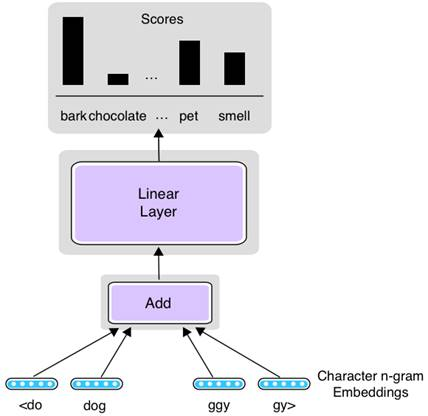


In [50]:
model = fasttext.train_supervised('/content/drive/My Drive/Colab Notebooks/AoIP/train.txt', wordNgrams = 2, label_prefix='__label__', epoch=10)

In [51]:
model.test('/content/drive/My Drive/Colab Notebooks/AoIP/test.txt')   

(1523, 0.7957977675640184, 0.7957977675640184)

In [33]:
test = [str(val) for val in df_test.values]
preds = [int(label[0][-1]) for label in model.predict(test)[0]]

In [34]:
res = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AoIP/sample_submission.csv')

In [36]:
res['target'] = preds
res.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [37]:
res.to_csv('/content/drive/My Drive/Colab Notebooks/AoIP/result_FastText.csv', index=False)